# Installation of dependencies

In [1]:
!pip install tensorflow tensorflow-gpu pandas matplotlib sklearn nltk

In [2]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
import nltk
import seaborn as sns
import matplotlib

# Data preprocessing################################
# Remove useless words
from nltk.corpus import stopwords

# Aggressive conversion of words to base form
from nltk.stem.lancaster import LancasterStemmer

# Import packages that help us to create document-term matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# Data preprocessing################################

# Data visualization################################

# For creating graphs
from matplotlib import pyplot as plt
# Data visualization################################

from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision

# Setting the dtype policy to utilize mixed precision
# This will use the tensor cores of the GPU
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060 Ti, compute capability 8.6


In [4]:
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

Compute dtype: float16
Variable dtype: float32


# 

# Load the dataset

In [6]:
os.path.join('train_colab', 'train.csv')

'train_colab\\train.csv'

In [7]:
df = pd.read_csv(os.path.join('train_colab', 'train.csv'))

In [8]:
df.iloc[3]['TextComment']

'china teammate so toxic'

In [9]:
df[df.columns[2:]].iloc[3]

Toxic              1
SevereToxicity     0
ObsceneLanguage    0
Insult             1
Name: 3, dtype: int64

#

# Dataset overview
The overview will conclude a discussion with the dataset using exploratory data analysis.

In [10]:
# Show rows of the dataset
len(df)

128606

In [11]:
# Check percentage of comments that are toxic compared to normal comments
df.Toxic.value_counts(normalize=True)

0    0.889655
1    0.110345
Name: Toxic, dtype: float64

This states that approximately 11.03% of the dataset is toxic compared to normal comments.

In [12]:
# Create a new subset of the data by only taking the 2nd column onwards (comments and categories)
df_count=df.iloc[:,2:].sum()

# Print dataset summary
df_count

Toxic              14191
SevereToxicity      1597
ObsceneLanguage     7889
Insult              7499
dtype: int64

# 

# Data visualization

In [13]:
print(df_count.index)

Index(['Toxic', 'SevereToxicity', 'ObsceneLanguage', 'Insult'], dtype='object')


C:\Anaconda\envs\tf_2.9\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


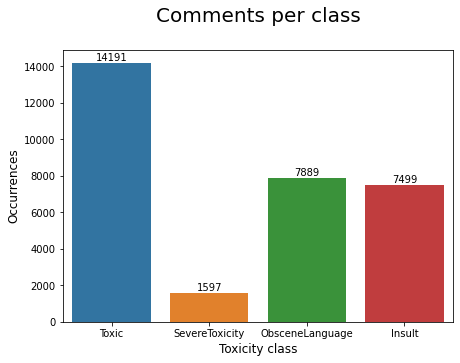

In [14]:
# Plot a chart with the following size
plt.figure(figsize=(7,5))

# Plot a bar chart using the index (category values) and the count of each category. 
# To make the bars more translucent, modify alpha value
ax = sns.barplot(df_count.index, df_count.values, alpha=1)

plt.title("Comments per class\n", fontsize=20)
plt.ylabel('Occurrences', fontsize=12)
plt.xlabel('Toxicity class', fontsize=12)

# Adding the text labels for each bar
rects = ax.patches
labels = df_count.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 10, label, ha='center', va='bottom')

plt.show()

In [15]:
rowdata = len(df)

pctdata = df_count.values / rowdata * 100
pctdata

array([11.0344774 ,  1.24177721,  6.13423946,  5.83098767])

### This concludes that the percentage of toxicity classes are:
    - Toxicity: 11.03%
    - Severe Toxicity: 1.24%
    - Obscene Language: 6.13%
    - Insult: 5.83%

#

# Data preprocessing

In [16]:
import re
from nltk.tokenize.treebank import TreebankWordDetokenizer

# Re-download stopwords for backup
nltk.download('stopwords')
nltk.download('punkt')

# Setup stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Maltesers\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Maltesers\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [17]:
# Remove numbers, capital letters, punctuation, '\n'
import re
import string

# Remove all random numbers with attached letters
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)

# '[%s]' % re.escape(string.punctuation),' ' - replace punctuation with white space
# .lower() - Convert all strings to lowercase 
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

# Remove all '\n' in the string and replace it with a space
filter_line = lambda x: re.sub("\n", " ", x)

# Remove all Non-ASCII characters 
filter_non_ascii = lambda x: re.sub(r'[^\x00-\x7f]',r' ', x)

# Apply all the lambda functions wrote previously through .map on the comments column
df['TextComment'] = df['TextComment'].map(alphanumeric).map(punc_lower).map(filter_line).map(filter_non_ascii)

In [19]:
# View comment
df['TextComment'][50000]

'your new user tags   hey man   i just noticed that you put a little tag on your user page saying that vandals dont like you  that is most certainly not the case    well  at least not as far as i m concerned  the only reason that i keep screwing around with you is because you re the only admin that s banned me who has a memorable  easy to spell name  honestly  it s nothing personal   just trying to put a smile on your face '

In [20]:
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.preprocessing import text, sequence

In [21]:
X = df['TextComment']
y = df[df.columns[2:]].values

In [22]:
df.columns

Index(['id', 'TextComment', 'Toxic', 'SevereToxicity', 'ObsceneLanguage',
       'Insult'],
      dtype='object')

In [23]:
df[df.columns[2:]]

,Toxic,SevereToxicity,ObsceneLanguage,Insult
0,0,1,0,1
1,0,1,1,1
2,0,0,0,0
3,1,0,0,1
4,0,0,0,0
...,...,...,...,...
128601,0,1,1,1
128602,0,0,0,1
128603,0,1,1,1
128604,0,0,0,0


In [24]:
MAX_WORDS = 250000 # number of words in the vocab

In [25]:
vectorizer = TextVectorization(max_tokens=MAX_WORDS,
                               output_sequence_length=1800,
                               output_mode='int')

In [27]:
type(X.values)

numpy.ndarray

In [28]:
vectorizer.adapt(X.values)

In [29]:
vectorized_text = vectorizer(X.values)

In [30]:
vectorizer('Hello, test')[:2]

<tf.Tensor: shape=(2,), dtype=int64, numpy=array([376, 698], dtype=int64)>

In [31]:
vectorized_text

<tf.Tensor: shape=(128606, 1800), dtype=int64, numpy=
array([[  112,   155,     3, ...,     0,     0,     0],
       [ 1117,    76,   188, ...,     0,     0,     0],
       [  322,   367,     4, ...,     0,     0,     0],
       ...,
       [25107,  6365,     0, ...,     0,     0,     0],
       [    6,    11,   525, ...,     0,     0,     0],
       [    6,     4,   123, ...,     0,     0,     0]], dtype=int64)>

In [32]:
len(X)

128606

In [33]:
# Particularly helpful if you have a large dataset
# This is a data pipeline
# MCShBP - map, cache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(130000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [34]:
batch_X, batch_y = dataset.as_numpy_iterator().next()

In [35]:
batch_X.shape

(16, 1800)

In [36]:
tf.data.Dataset.list_files

<function tensorflow.python.data.ops.dataset_ops.DatasetV2.list_files(file_pattern, shuffle=None, seed=None, name=None)>

In [37]:
train = dataset.take(int(len(dataset)*0.7))
val = dataset.skip(int(len(dataset)*0.7)).take(int(len(dataset)*0.2))
test = dataset.skip(int(len(dataset)*0.9)).take(int(len(dataset)*0.1))

In [38]:
train_generator = train.as_numpy_iterator()

In [39]:
train_generator.next()

(array([[  1042,    171,    517, ...,      0,      0,      0],
        [     4,     20,     31, ...,      0,      0,      0],
        [106289,      6,     31, ...,      0,      0,      0],
        ...,
        [   376,    807,  22944, ...,      0,      0,      0],
        [    55,     33,     15, ...,      0,      0,      0],
        [    10,     27,     12, ...,      0,      0,      0]], dtype=int64),
 array([[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [1, 0, 1, 1],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]], dtype=int64))

# Sequential Models

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [41]:
#Bidirectional??

In [42]:
#LSTM??

In [43]:
#Dense??

In [44]:
# v4-2-1 #######################################################
# Adjusted the model Dropouts to 0.2
# Adjusted Dense layers back to 128-256
# Using optimizer, Adam
# 10 Epoch + removed stopwords yielded 92 92 47
################################################################

#v4-2-2 ########################################################
# Adjusted the model Dropouts to 0.3
# Adjusted Dense layers to 128-64
# Specified optimizer learning rate, Adam 0.0001
# 10 Epoch + no stopwords yielded to 83 83 50
################################################################

#v4-2-3 ########################################################
# Adjusted the model Dropouts back to 0.2
# No Adjustment on Dense layers
# Still using optimizer Adam with learning rate 0.0001
# 10 Epoch + re-added stopwords yielded to 84 80 49
################################################################

#v4-2-4 ########################################################
# Adjusted the model Dropouts back to 0.2
# Adjusted Dense layers to 256-128
# Still using optimizer Adam with learning rate 0.0001
# 10 Epoch + no stopwords yielded to 83 82 44
################################################################

#v4-2-5 ########################################################
# Adjusted the model Dropouts back to 0.2
# Adjusted Dense layers back to 128-256
# Using Adam without specified learning rate
# 10 Epoch + no stopwords yielded to 92 91 67
# Adjusted performance metric to Accuracy()
################################################################

#v4-2-6 ########################################################
# Dropouts 0.2
# Dense layers 128-256
# Using Adam without specified learning rate
# 20 Epoch + no stopwords yielded to 97 96 86
################################################################

model = Sequential()

# Create the embedding layer
model.add(Embedding(MAX_WORDS+1, 32))

# Dropout layer
model.add(Dropout(0.2))

# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))

# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))

# Dropout layer
model.add(Dropout(0.2))

# Final layer 
model.add(Dense(4, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          8000032   
                                                                 
 dropout (Dropout)           (None, None, 32)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                        

In [45]:
# We will use Adam
# Adam(learning rate)
#optimizers = tf.keras.optimizers.Adam(0.0001)

In [46]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

# Training the model and displaying chart containing Loss and Validation Loss
**_val_loss_** is the value of cost function for your cross-validation data. <br>
**_loss_** is the value of cost function for your training data.

On validation data, neurons using drop out do not drop random neurons. The reason is that during training we use drop out in order to add some noise for avoiding over-fitting. During calculating cross-validation, we are in the recall phase and not in the training phase. We use all the capabilities of the network.

In [47]:
# Train the dataset
# Epoch = how many passes for dataset
batch_size=64
archive=model.fit(train, epochs=20, validation_data=val)

Epoch 1/20
5626/5626 [==============================] - 451s 79ms/step - loss: 0.0924 - val_loss: 0.0665
Epoch 2/20
5626/5626 [==============================] - 440s 78ms/step - loss: 0.0664 - val_loss: 0.0576
Epoch 3/20
5626/5626 [==============================] - 438s 78ms/step - loss: 0.0594 - val_loss: 0.0577
Epoch 4/20
5626/5626 [==============================] - 439s 78ms/step - loss: 0.0540 - val_loss: 0.0506
Epoch 5/20
5626/5626 [==============================] - 437s 78ms/step - loss: 0.0502 - val_loss: 0.0437
Epoch 6/20
5626/5626 [==============================] - 438s 78ms/step - loss: 0.0464 - val_loss: 0.0411
Epoch 7/20
5626/5626 [==============================] - 439s 78ms/step - loss: 0.0427 - val_loss: 0.0411
Epoch 8/20
5626/5626 [==============================] - 438s 78ms/step - loss: 0.0400 - val_loss: 0.0336
Epoch 9/20
5626/5626 [==============================] - 439s 78ms/step - loss: 0.0368 - val_loss: 0.0300
Epoch 10/20
5626/5626 [==============================] 

In [48]:
from matplotlib import pyplot as plt

<Figure size 576x360 with 0 Axes>

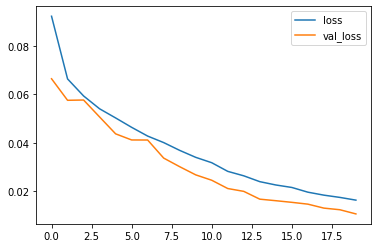

In [49]:
plt.figure(figsize=(8,5))
pd.DataFrame(archive.history).plot()
plt.show()

# Save model after training, load model function(H5)

In [50]:
# Save data after training Epoch10_v4-2-5
model.save('epoch20_v4-2-6.h5')
# Load model data
model = tf.keras.models.load_model('epoch20_v4-2-6.h5')

# Prediction data

In [51]:
input_text = vectorizer('russian idiot noob')

In [52]:
df.columns[2:]

Index(['Toxic', 'SevereToxicity', 'ObsceneLanguage', 'Insult'], dtype='object')

In [53]:
model.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 1s 621ms/step


array([[0.9893, 0.093 , 0.654 , 0.991 ]], dtype=float16)

In [54]:
batch = test.as_numpy_iterator().next()

In [55]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [56]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 0s 59ms/step


array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [1, 0, 1, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [1, 0, 1, 1],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]])

In [57]:
res = model.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 0s 55ms/step


In [58]:
res

array([[0.9893, 0.093 , 0.654 , 0.991 ]], dtype=float16)

In [59]:
res.shape

(1, 4)

# Model Evaluation

In [60]:
from tensorflow.keras.metrics import Precision, Recall, Accuracy

In [61]:
model_pre = Precision()
model_rec = Recall()
model_acc = Accuracy()

In [62]:
for batch in test.as_numpy_iterator(): 
    
    # Unpack the batch 
    X_true, y_true = batch
    
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    model_pre.update_state(y_true, yhat)
    model_rec.update_state(y_true, yhat)
    model_acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 39ms/step


In [63]:
print(f'Precision: {model_pre.result().numpy()},Recall:{model_rec.result().numpy()}, Accuracy:{model_acc.result().numpy()}')

Precision: 0.9725568890571594,Recall:0.9612967371940613, Accuracy:0.868773341178894


# 5. Test and Gradio

In [64]:
!pip install gradio jinja2

In [65]:
import tensorflow as tf
import gradio as gr

In [66]:
input_str = vectorizer('fucking noob china man')

In [67]:
res = model.predict(np.expand_dims(input_str,0))

1/1 [==============================] - 0s 69ms/step


In [68]:
res

array([[1.    , 0.2173, 1.    , 0.9707]], dtype=float16)

In [69]:
def score_comment(Chat):
    vectorized_comment = vectorizer([Chat])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

In [70]:
interface = gr.Interface(fn=score_comment, 
                         inputs=gr.inputs.Textbox(lines=2, placeholder='Type to evaluate'),
                        outputs='text')

C:\Anaconda\envs\tf_2.9\lib\site-packages\gradio\inputs.py:26: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
C:\Anaconda\envs\tf_2.9\lib\site-packages\gradio\deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
C:\Anaconda\envs\tf_2.9\lib\site-packages\gradio\deprecation.py:40: UserWarning: `numeric` parameter is deprecated, and it has no effect
  warnings.warn(value)
C:\Anaconda\envs\tf_2.9\lib\site-packages\gradio\deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)


In [71]:
interface.launch(share=False)

Running on local URL:  http://127.0.0.1:7860/

To create a public link, set `share=True` in `launch()`.


(<gradio.routes.App at 0x1cd50e30670>, 'http://127.0.0.1:7860/', None)

1/1 [==============================] - 0s 283ms/step
